# Predicting the amount of gold recovered from gold ore.

This project uses data provided by Zyfra.
We are tasked with preparing a prototype of a machine learning model for Zyfra. The company develops efficiency solutions for heavy industry.

The model should predict the amount of gold recovered from gold ore. 

The model will help to optimize the production and eliminate unprofitable parameters.

We need to:
- Prepare the data;
- Perform data analysis;
- Develop and train a model.

In [1]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from scipy import stats as st

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer

import seaborn as sns

import statistics

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
plt.style.use('seaborn-pastel')

## Data preprocessing

### Initial exploratory analysis

In [3]:
#importing data
df_train = pd.read_csv('/datasets/gold_recovery_train.csv')
df_test = pd.read_csv('/datasets/gold_recovery_test.csv')
df_full = pd.read_csv('/datasets/gold_recovery_full.csv')

In [4]:
#function to print key info
def preliminary_analysis(df):
    print(df.info())
    print("""
    
    """)
    print(df.describe())
    print("""
    
    """)
    return df.head()


In [5]:
preliminary_analysis(df_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

In [6]:
preliminary_analysis(df_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.50

In [7]:
preliminary_analysis(df_full)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

The dataframe df_full appears to contain all the data from the train and test set, but the datafram df_test is missing a number of columns.

We should be able to merge df_test with df_full to aquire those missing columns which will allow us to use those features in our model.

We'll set the datetime to our index to assist with this.

In [8]:
#setting date to a datetime index
for df in [df_full, df_train, df_test]:
    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"])
        df.set_index("date", inplace=True)

It is important to checck that recovery is calculated correctly. Using the training set, we'll calculate recovery for the rougher.output.recovery feature and find the MAE between our calculations and the feature values. 

In [9]:
#creating a function to calculate recovery
def calculate_recovery(c,f,t): 
    """
    for finding rougher concentrate recovery/for finding final concntrate recovery
    c: share of gold in share of gold in the concentrate right after flotation /after purification 
    f: share of gold in the feed before flotation /in the concentrate right after flotation 
    t: share of gold in the rougher tails right after flotation /after purification
    """
    
    try:
        recovery = ((c*(f-t))/(f*(c-t)))*100
    except:
        recovery = np.nan
        
    return recovery #recovery as a percentage
    

In [10]:
#creating a column of recovery predictions
df_train['recovery_predictions'] = df_train.apply(lambda x: calculate_recovery(x['rougher.output.concentrate_au'], x['rougher.input.feed_au'], x['rougher.output.tail_au']), axis=1)

/tmp/ipykernel_97/1863206389.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  recovery = ((c*(f-t))/(f*(c-t)))*100
/tmp/ipykernel_97/1863206389.py:8: RuntimeWarning: invalid value encountered in double_scalars
  recovery = ((c*(f-t))/(f*(c-t)))*100


In [11]:
df_train['recovery_predictions'].describe()

count    1.457700e+04
mean              NaN
std               NaN
min              -inf
25%      7.965104e+01
50%      8.521533e+01
75%      9.019726e+01
max               inf
Name: recovery_predictions, dtype: float64

In [12]:
df_train['rougher.output.recovery'].describe()

count    14287.000000
mean        82.394201
std         15.096808
min          0.000000
25%         79.818372
50%         85.235997
75%         90.131691
max        100.000000
Name: rougher.output.recovery, dtype: float64

We can see that the predictions currently contain some errata. Let's take a look at what produced the erroneous values.

In [13]:
#checking data that gave impossible predictions
df_train[(df_train['recovery_predictions'] <0)| (df_train['recovery_predictions'] >100)][['rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.tail_au', 'recovery_predictions', 'rougher.output.recovery']]

,rougher.output.concentrate_au,rougher.input.feed_au,rougher.output.tail_au,recovery_predictions,rougher.output.recovery
date,,,,,
2016-01-17 05:00:00,3.507147,7.548341,2.187465,1.887421e+02,NaN
2016-01-30 12:00:00,4.642559,0.139652,2.574309,-3.913313e+03,NaN
2016-01-30 17:00:00,15.084039,3.501578,5.964024,-1.163121e+02,NaN
2016-02-07 08:00:00,19.619751,1.921101,1.939904,-1.086185e+00,NaN
2016-02-13 04:00:00,1.483835,0.253075,1.477470,-1.127899e+05,NaN
2016-02-17 20:00:00,16.561142,1.489851,2.483197,-7.843480e+01,NaN
2016-02-18 19:00:00,5.966380,11.209605,1.359009,1.137968e+02,NaN
2016-02-18 21:00:00,8.347044,11.484935,1.521192,1.060889e+02,NaN
2016-03-02 20:00:00,15.745147,0.460536,1.812582,-3.317745e+02,NaN


It may well be that many of these come from incorrect measurements or errors in the process that led to, for example, no gold in the rougher input.

We can also see that these led to NaN values for the output recovery, one of our target variables.

We can drop these rows from our dataframes.

In [14]:
#dropping rows with errata
dates_to_drop = df_train.loc[df_train['rougher.output.recovery'].isnull()].index.to_list()
df_full = df_full[~df_full.index.isin(dates_to_drop)]
df_train.dropna(subset=['rougher.output.recovery'], inplace = True)

In [15]:
len(dates_to_drop)

2573

In [16]:
#checking predictions after rows removed
df_train['recovery_predictions'].describe()

count    14287.000000
mean        82.394201
std         15.096808
min         -0.000000
25%         79.818372
50%         85.235997
75%         90.131691
max        100.000000
Name: recovery_predictions, dtype: float64

These predictions now seem much mroe reasonable, let's check the MAE.

In [17]:
#calculating MAE
mean_absolute_error(df_train['rougher.output.recovery'], df_train['recovery_predictions'])

9.303415616264301e-15

An incredibly small number, it appears the calculations are now correct.

In [18]:
#dropping predictions
df_train.drop('recovery_predictions', axis = 1, inplace = True)

Now to check the missing values.

In [19]:
df_train.isna().sum()

final.output.concentrate_ag                              5
final.output.concentrate_pb                              5
final.output.concentrate_sol                           232
final.output.concentrate_au                              4
final.output.recovery                                  138
final.output.tail_ag                                     0
final.output.tail_pb                                   114
final.output.tail_sol                                    8
final.output.tail_au                                     0
primary_cleaner.input.sulfate                           26
primary_cleaner.input.depressant                        38
primary_cleaner.input.feed_size                          0
primary_cleaner.input.xanthate                         105
primary_cleaner.output.concentrate_ag                    0
primary_cleaner.output.concentrate_pb                  123
primary_cleaner.output.concentrate_sol                 338
primary_cleaner.output.concentrate_au                   

There are a relatively small number of missing values accross a range of columns.
In the project description we are told that : "Parameters that are next to each other in terms of time are often similar."
The natural way to fill in these values would therefore be ffill;  propagating last valid observation forward.

In [20]:
#removing any rows with missing targets
df_train = df_train[~df_train['final.output.recovery'].isna()]
df_train = df_train.fillna(method='ffill')

In [21]:
#checking for missing values
df_train.isna().sum()

final.output.concentrate_ag                           0
final.output.concentrate_pb                           0
final.output.concentrate_sol                          0
final.output.concentrate_au                           0
final.output.recovery                                 0
final.output.tail_ag                                  0
final.output.tail_pb                                  0
final.output.tail_sol                                 0
final.output.tail_au                                  0
primary_cleaner.input.sulfate                         0
primary_cleaner.input.depressant                      0
primary_cleaner.input.feed_size                       0
primary_cleaner.input.xanthate                        0
primary_cleaner.output.concentrate_ag                 0
primary_cleaner.output.concentrate_pb                 0
primary_cleaner.output.concentrate_sol                0
primary_cleaner.output.concentrate_au                 0
primary_cleaner.output.tail_ag                  

Before we fill missing values, let's add the target variables to the test set.

In [22]:
df_test = df_test.merge(df_full[['final.output.recovery', 'rougher.output.recovery']], how='left', left_index=True, right_index=True)

In [23]:
#checking missing valeus
df_test.isna().sum()

primary_cleaner.input.sulfate                 302
primary_cleaner.input.depressant              284
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                166
primary_cleaner.state.floatbank8_a_air         16
primary_cleaner.state.floatbank8_a_level       16
primary_cleaner.state.floatbank8_b_air         16
primary_cleaner.state.floatbank8_b_level       16
primary_cleaner.state.floatbank8_c_air         16
primary_cleaner.state.floatbank8_c_level       16
primary_cleaner.state.floatbank8_d_air         16
primary_cleaner.state.floatbank8_d_level       16
rougher.input.feed_ag                          16
rougher.input.feed_pb                          16
rougher.input.feed_rate                        40
rougher.input.feed_size                        22
rougher.input.feed_sol                         67
rougher.input.feed_au                          16
rougher.input.floatbank10_sulfate             257
rougher.input.floatbank10_xanthate            123


Again, a small number, let's follow the same process as above

In [24]:
#removing rows with missing targets and filling missing values
df_test = df_test[~df_test['final.output.recovery'].isna()]
df_test = df_test[~df_test['rougher.output.recovery'].isna()]
df_test = df_test.fillna(method='ffill')

In [25]:
#checking for no missing valeus
df_test.isna().sum()

primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate            0
rougher.input.floatbank11_sulfate       

## Analysing the data


Let's visualise  how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage.


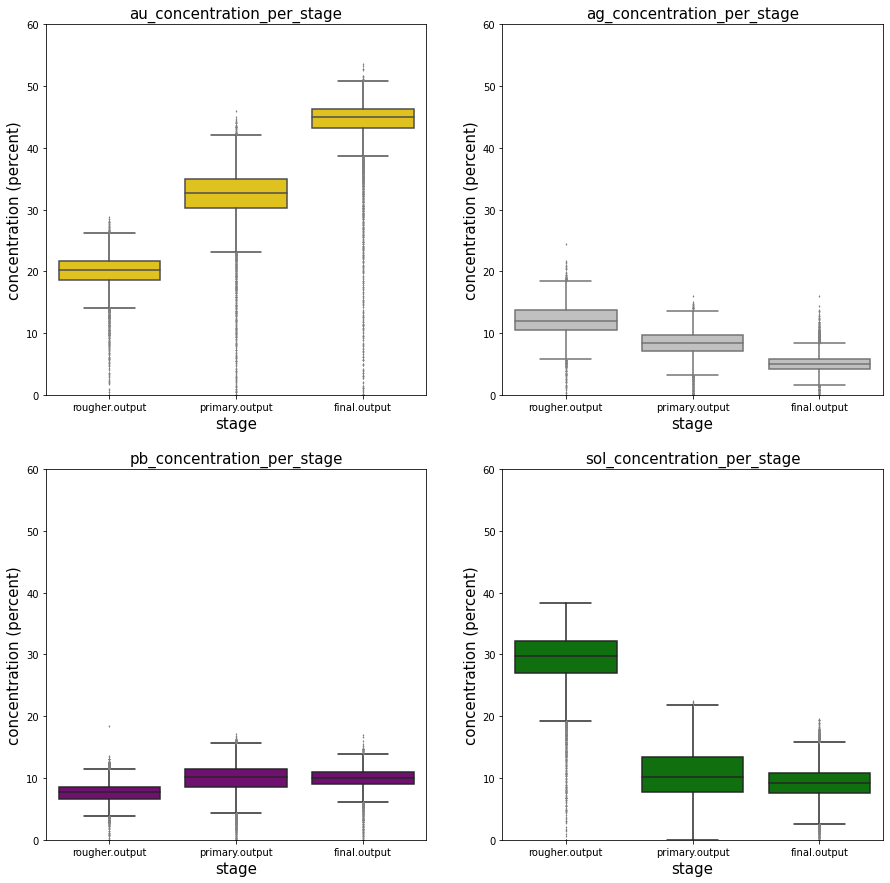

In [26]:
#creating plot of concentration changes per stage
fig, axs = plt.subplots(ncols=2, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(15,15)
axes = [axs[0,0], axs[0,1], axs[1,0], axs[1,1]]
flierprops = dict(markerfacecolor = 'grey', markersize = 2, markeredgecolor='none')
    
sns.boxplot(data=[df_full['rougher.output.concentrate_au'],df_full['primary_cleaner.output.concentrate_au'], df_full['final.output.concentrate_au']], ax=axs[0,0], color='gold', flierprops = flierprops).set(title='au_concentration_per_stage', ylabel = 'concentration (percent)', xlabel = 'stage')
sns.boxplot(data=[df_full['rougher.output.concentrate_ag'],df_full['primary_cleaner.output.concentrate_ag'], df_full['final.output.concentrate_ag']], ax=axs[0,1], color='silver', flierprops = flierprops).set(title='ag_concentration_per_stage', ylabel = 'concentration (percent)', xlabel = 'stage')
sns.boxplot(data=[df_full['rougher.output.concentrate_pb'],df_full['primary_cleaner.output.concentrate_pb'], df_full['final.output.concentrate_pb']], ax=axs[1,0], color='purple', flierprops = flierprops).set(title='pb_concentration_per_stage', ylabel = 'concentration (percent)', xlabel = 'stage')
sns.boxplot(data=[df_full['rougher.output.concentrate_sol'],df_full['primary_cleaner.output.concentrate_sol'], df_full['final.output.concentrate_sol']], ax=axs[1,1], color='green', flierprops = flierprops).set(title='sol_concentration_per_stage', ylabel = 'concentration (percent)', xlabel = 'stage')

for ax in axes:
    ax.set_xticklabels(['rougher.output','primary.output','final.output'], fontsize = 10)
    ax.set_ylim(0,60)
    ax.xaxis.get_label().set_fontsize(15)
    ax.yaxis.get_label().set_fontsize(15)
    ax.title.set_fontsize(15)

We can see that concentration steadily increases through the stages, silver steadily decreases whilst lead concentration increases slightly from rougher.output to primary.output then stays approximately the same in the final.output

Let's compare the feed particle size distributions in the training set and in the test set. If the distributions vary significantly, the model evaluation will be incorrect.

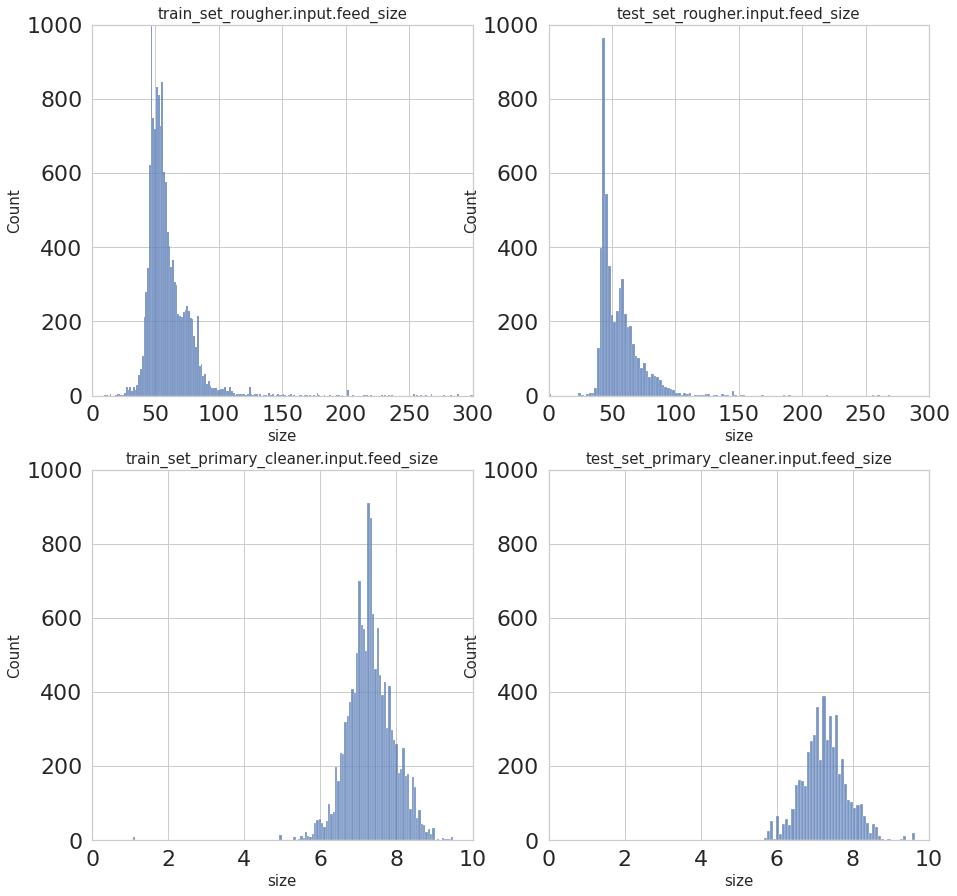

In [27]:
#plotting distributions
fig, axs = plt.subplots(ncols=2, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 1)
fig.set_size_inches(15,15)
axes = [axs[0,0], axs[0,1], axs[1,0], axs[1,1]]
flierprops = dict(markerfacecolor = 'grey', markersize = 2, markeredgecolor='none')
    
sns.histplot(data=df_train['rougher.input.feed_size'], ax=axs[0,0]).set(title='train_set_rougher.input.feed_size',  xlabel = 'size')
axs[0,0].set_ylim(0,1000)
axs[0,0].set_xlim(0,300)
sns.histplot(data=df_test['rougher.input.feed_size'], ax=axs[0,1]).set(title='test_set_rougher.input.feed_size',  xlabel = 'size')
axs[0,1].set_ylim(0,1000)
axs[0,1].set_xlim(0,300)
sns.histplot(data=df_train['primary_cleaner.input.feed_size'], ax=axs[1,0]).set(title='train_set_primary_cleaner.input.feed_size',  xlabel = 'size')
axs[1,0].set_xlim(0,10)
axs[1,0].set_ylim(0,1000)
sns.histplot(data=df_test['primary_cleaner.input.feed_size'], ax=axs[1,1]).set(title='test_set_primary_cleaner.input.feed_size',  xlabel = 'size')
axs[1,1].set_xlim(0,10)
axs[1,1].set_ylim(0,1000)

#sns.boxplot(data=[df_train['primary_cleaner.input.feed_size'],df_test['primary_cleaner.input.feed_size']], ax=axs[1], flierprops = flierprops).set(title='primary_cleaner.input.feed_size', ylabel = 'size', xlabel = 'set')
#axs[1].set_ylim(0,10)
#sns.boxplot(data=[df_train['rougher.output.concentrate_ag'],df_train['primary_cleaner.output.concentrate_ag'], df_train['final.output.concentrate_ag']], ax=axs[0,1], color='silver', flierprops = flierprops).set(title='ag_concentration_per_stage')

for ax in axes:
    #ax.set_xticklabels(['train', 'test',], fontsize = 10)
    
    ax.xaxis.get_label().set_fontsize(15)
    ax.yaxis.get_label().set_fontsize(15)
    ax.title.set_fontsize(15)

The rougher.input.feed_size distributions appear to vary more then the primary_cleaner.input.feed_size.
In order to caculate if they are significantly different, we can perform an independent t-test for two samples. 
We can do this as the data ppears to be normally distributed, we will however have to first remove some of the extreme outliers, namely those more than 3 standard deviations from the mean.


In [28]:
#defining function to remove outliers
def remove_outliers(data):
    data_mean, data_std = np.mean(data), np.std(data)
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off
    outliers_removed = [x for x in data if x > lower and x < upper]
    return pd.Series(outliers_removed)

In [29]:
# removing outliers, checking means and performing the ttest
feed_sizes = ['rougher.input.feed_size', 'primary_cleaner.input.feed_size']
for f in feed_sizes:
    data_train = remove_outliers(df_train[f])
    data_test = remove_outliers(df_test[f])
    
    print(f,"""
    """)
    print(f'Train set mean: {data_train.mean():.2f}, Test set mean: {data_test.mean():.2f}')
    print(f'Train set variance: {statistics.variance(data_train.dropna()):.2f}, Test set variance: {statistics.variance(data_test.dropna()):.2f}')

    
    alpha = 0.05
    
    print("""
    H0: μ1 = μ2 (the two population means are equal)
    H1: μ1 != μ2 (the two population means are not equal)
    """)
    print(f'Testing at a {alpha} significance level')
    
    pvalue = st.ttest_ind(data_train, data_test, nan_policy = 'omit', equal_var = True).pvalue

    print('p-value: ', pvalue)

    if pvalue < alpha:
        print(
            "Reject null hypothesis: the two population means are not equal"
        )
    else:
        print(
            "Failed to reject null hypothesis: the two population means are equal"
        )

    print("""
        ------------------------------""")   

rougher.input.feed_size 
    
Train set mean: 58.60, Test set mean: 54.84
Train set variance: 192.19, Test set variance: 190.55

    H0: μ1 = μ2 (the two population means are equal)
    H1: μ1 != μ2 (the two population means are not equal)
    
Testing at a 0.05 significance level
p-value:  8.937746182764508e-63
Reject null hypothesis: the two population means are not equal

        ------------------------------
primary_cleaner.input.feed_size 
    
Train set mean: 7.32, Test set mean: 7.25
Train set variance: 0.34, Test set variance: 0.32

    H0: μ1 = μ2 (the two population means are equal)
    H1: μ1 != μ2 (the two population means are not equal)
    
Testing at a 0.05 significance level
p-value:  1.493959184483575e-16
Reject null hypothesis: the two population means are not equal

        ------------------------------


The distributions in the test and train set differ. In order to make sure our model is valid, we can remove these columns.

In [30]:
#dropping feed sizes
df_train.drop(['rougher.input.feed_size', 'primary_cleaner.input.feed_size'], axis = 1, inplace = True)
df_test.drop(['rougher.input.feed_size', 'primary_cleaner.input.feed_size'], axis = 1, inplace = True)
df_full.drop(['rougher.input.feed_size', 'primary_cleaner.input.feed_size'], axis = 1, inplace = True)

Lets consider the total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate. We'll check for any outliers and remove them if necessary.

In [31]:
#getting a list of all features concerning concentrations
concentrations =[x for x in df_train.columns if 'concentrate' in x]  
print (concentrations)

['final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.concentrate_au', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.concentrate_au', 'rougher.calculation.sulfate_to_au_concentrate', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol', 'rougher.output.concentrate_au']


In [32]:
#function to check the percent of outliers.
def check_for_outliers(df, cols, sigmas=3):
    for col in cols:
        data = df[col].dropna()
        data_mean, data_std = np.mean(data), np.std(data)
        cut_off = data_std * sigmas
        lower, upper = data_mean - cut_off, data_mean + cut_off
        outliers = [x for x in data if (x < lower) or (x > upper)]
        percent_outliers = (len(outliers)/len(data))*100
        print(f'{col}, outliers: {percent_outliers:.2f}%')
        


In [33]:
check_for_outliers(df_full, concentrations, 3)

final.output.concentrate_ag, outliers: 3.20%
final.output.concentrate_pb, outliers: 2.82%
final.output.concentrate_sol, outliers: 2.45%
final.output.concentrate_au, outliers: 3.09%
primary_cleaner.output.concentrate_ag, outliers: 3.42%
primary_cleaner.output.concentrate_pb, outliers: 3.31%
primary_cleaner.output.concentrate_sol, outliers: 0.00%
primary_cleaner.output.concentrate_au, outliers: 3.72%
rougher.calculation.sulfate_to_au_concentrate, outliers: 0.50%
rougher.output.concentrate_ag, outliers: 4.02%
rougher.output.concentrate_pb, outliers: 4.00%
rougher.output.concentrate_sol, outliers: 4.14%
rougher.output.concentrate_au, outliers: 4.08%


There is a small percentage of extreme outliers, we can drop these without issue.

In [34]:
def drop_outliers(df, cols, sigmas=3):
    outliers_dropped = 0
    for col in cols:
        data = df[col].dropna()
        data_mean, data_std = np.mean(data), np.std(data)
        cut_off = data_std * sigmas
        lower, upper = data_mean - cut_off, data_mean + cut_off
        to_drop = df.loc[(df[col]<lower) | (df[col]>upper)]
        o = len(to_drop)
        df.drop(to_drop.index, inplace = True)
        
        outliers_dropped += o
    print(f'outliers dropped: {outliers_dropped}')
    return df
        
    

In [35]:
#dropping rows with outliers
df_full = drop_outliers(df_full, concentrations, 3)
df_train = df_train[df_train.index.isin(df_full.index.tolist())]
df_test = df_test[df_test.index.isin(df_full.index.tolist())]

outliers dropped: 2883


## Building the model
We'll train  number different models and evaluate them using cross-validation. 
To evaluate our model, we'll use the symmetric Mean Absolute Percentage Error and our final metric will be a weigted sMAPE.

We'll use these formulas for our evaluation metrics:

$sMAPE= \frac{1}{N} \sum_{i=1}^{N} \frac {|y_i-\hat{y_i}|}{(|y_i|+|\hat{y_i}|)/2} \times 100\% $

$Final\hspace{0.2cm}sMAPE = 25\% \times sMAPE(rougher) + 75\% \times sMAPE(final)$

We'll create a custom scorer in SKLearn in order to evaluate our models.

### Writing a function to calculate the final sMAPE value.

In [36]:
def smape(y_true, y_pred):
    fraction = np.divide(np.abs(y_true - y_pred), (np.abs(y_true)+np.abs(y_pred))/2)
    return np.average(fraction, axis=0)

In [37]:
def smape_final(y_true,y_pred):
    
    smape_out_rougher = smape(y_true[target.index('rougher.output.recovery')], y_pred[target.index('rougher.output.recovery')])
    
    smape_out_final = smape(y_true[target.index('final.output.recovery')], y_pred[target.index('final.output.recovery')])
    
    return 0.25*smape_out_rougher + 0.75*smape_out_final

In order to use our metric in grid search, we will set greater_is_better = False, this will actually output sMAPE*-1, so when displaying results we will take the absolute value.

In [38]:
smape_score = make_scorer(smape_final, greater_is_better = False)

In [39]:
#setting targets and features
target = ['rougher.output.recovery', 'final.output.recovery']
features = df_test[df_test.columns.difference(target)].columns.tolist()

In [40]:
#defining train and test splits
X_train, X_test = df_train[features].values, df_test[features].values
y_train, y_test = df_train[target].values, df_test[target].values

In [41]:
# testing linear regression
lr = LinearRegression().fit(X_train, y_train)
scores_lr = cross_val_score(lr, X_train, y_train, cv=5, scoring=smape_score)
print("mean train cv smape:", abs(scores_lr.mean()))
print('cv scores :', [abs(x) for x in scores_lr])
print("""
""")
#test set
scores_lr_test = cross_val_score(lr, X_test, y_test, cv=5, scoring=smape_score)
print("mean test cv smape:", abs(scores_lr_test.mean()))
print('cv scores :',[abs(x) for x in scores_lr_test])
print("""
""")

mean train cv smape: 0.06570762482231438
cv scores : [0.029481593370556093, 0.07938284662897081, 0.1278062146621214, 0.05491213682195105, 0.03695533262797251]


mean test cv smape: 0.03564477984629483
cv scores : [0.05141286894170725, 0.027666374154077876, 0.052071189322376754, 0.016005270620643712, 0.03106819619266854]




In [42]:
#testing decision tree regressor 

#defining parameters for grid search
params = {'min_samples_split': [2,5,10], 'max_depth': range(5,15,1), 'max_features': ['auto','sqrt']}
g_cv = GridSearchCV(DecisionTreeRegressor(random_state=1),param_grid=params,scoring=smape_score, cv=5, refit=True)
g_cv.fit(X_train, y_train)
best_params = g_cv.best_params_

#testing with best params
dtr = DecisionTreeRegressor(**best_params).fit(X_train, y_train)
scores_dtr = cross_val_score(dtr, X_train, y_train, cv=5, scoring=smape_score)
print("mean train cv smape:", abs(scores_dtr.mean()))
print('cv scores :', [abs(x) for x in scores_dtr])
print("""
""")
#test set
scores_dtr_test = cross_val_score(dtr, X_test, y_test, cv=5, scoring=smape_score)
print("mean test cv smape:", abs(scores_dtr_test.mean()))
print('cv scores :',[abs(x) for x in scores_dtr_test])
print("""
""")

mean train cv smape: 0.07947826842350708
cv scores : [0.21756281637424604, 0.09299667030119259, 0.013160044356267206, 0.05560196192079378, 0.018069849165035814]


mean test cv smape: 0.03617970664010537
cv scores : [0.00899607410866105, 0.010798963048368086, 0.01908944491891578, 0.08435818412155294, 0.05765586700302899]




In [43]:
#testing random forest regressor 

#defining parameters for grid search
params = {'min_samples_split': [2,5,10], 'max_depth': range(5,15,1)}
rf_cv = GridSearchCV(RandomForestRegressor(random_state=1),param_grid=params,scoring=smape_score, cv=5, refit=True)
rf_cv.fit(X_train, y_train)
best_params = rf_cv.best_params_

#testing with best params
rfr = RandomForestRegressor(**best_params).fit(X_train, y_train)
scores_rfr = cross_val_score(rfr, X_train, y_train, cv=5, scoring=smape_score)
print("mean train cv smape:", abs(scores_rfr.mean()))
print('cv scores :', [abs(x) for x in scores_rfr])
print("""
""")
#test set
scores_rfr_test = cross_val_score(rfr, X_test, y_test, cv=5, scoring=smape_score)
print("mean test cv smape:", abs(scores_rfr_test.mean()))
print('cv scores :',[abs(x) for x in scores_rfr_test])
print("""
""")

mean train cv smape: 0.04909032212525154
cv scores : [0.12306595367983154, 0.07044334221787542, 0.02311415486638943, 0.01853482909732361, 0.01029333076483767]


mean test cv smape: 0.03592557482520854
cv scores : [0.033486516530981, 0.00488951945784615, 0.03749801266467983, 0.04822190990920911, 0.05553191556332662]




## Conclusion

In this project we:
- Processed our data
     - removing missing, erroneous and outlier values, adding recovery predictions through calculations
- Analysed our data
    - inspected concentrations throughout the process, statistically analysed the features in the train and test set
- Built out model
    - creating a custom sMAPE function to measure performance, compared different model and hyperparameter performances


This resulted in our final model, the RandomForestRegressor, which had a mean cv score of 0.049 on our train set and 0.036 on our test set.
